# Lesion classification with Inception ResNet V2

__TL;DR__

We use [Inception ResNet V2](#Inception-ResNet-V2) for lesion classification in general, and [melanoma](#Melanoma) diagnosis in particular, in order to establish the baseline for performance.

In [1]:
import os
import datetime
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.cm as cm
import matplotlib.pyplot as plt

from IPython.display import Image, display
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split


from random import shuffle

# Melanoma

__Melanoma__, also redundantly known as __malignant melanoma__, is a type of skin cancer that develops from the pigment-producing cells known as melanocytes. Melanomas typically occur in the skin, but may rarely occur in the mouth, intestines, or eye (uveal melanoma). In women, they most commonly occur on the legs, while in men, they most commonly occur on the back. About 25% of melanomas develop from moles. Changes in a mole that can indicate melanoma include an increase in size, irregular edges, change in color, itchiness, or skin breakdown.

![melanoma image](../assets/melanoma.jpg)

Pic.1. A melanoma of approximately 2.5 cm (1 in) by 1.5 cm (0.6 in)

The primary cause of melanoma is ultraviolet light (UV) exposure in those with low levels of the skin pigment melanin. The UV light may be from the sun or other sources, such as tanning devices. Those with many moles, a history of affected family members, and poor immune function are at greater risk. A number of rare genetic conditions, such as xeroderma pigmentosum, also increase the risk. Diagnosis is by biopsy and analysis of any skin lesion that has signs of being potentially cancerous.

Melanoma is the most dangerous type of skin cancer. Globally, in 2012, it newly occurred in 232,000 people. In 2015, 3.1 million people had active disease, which resulted in 59,800 deaths. Australia and New Zealand have the highest rates of melanoma in the world. High rates also occur in Northern Europe and North America, while it is less common in Asia, Africa, and Latin America. In the United States, melanoma occurs about 1.6 times more often in men than women. Melanoma has become more common since the 1960s in areas mostly populated by people of European descent.

# Inception ResNet V2

__Inception ResNet V2__ is a convolutional neural architecture that builds on the Inception family of architectures but incorporates residual connections (replacing the filter concatenation stage of the Inception architecture).

![CNN image](../assets/inception_resnet_v2.png)

Pic.2. Inception ResNetv 2 architecture

If you want to learn more about Inception ResNet v2, read [here](https://paperswithcode.com/method/inception-resnet-v2).

# Data research

We load the __metadata.csv__, which contains information about each image.

In [2]:
metadata = pd.read_csv(f"{os.environ['SCRATCH']}/isic-archive/metadata.csv")
metadata

<ipython-input-1-00b3083c4fdc>:1: DtypeWarning: Columns (3,11,12,14,15,17,18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv(f"{os.environ['SCRATCH']}/isic-archive/metadata.csv")


,isic_id,sex,diagnosis,mel_class,mel_thick_mm,benign_malignant,anatom_site_general,diagnosis_confirm_type,age_approx,melanocytic,acquisition_day,mel_type,nevus_type,clin_size_long_diam_mm,dermoscopic_type,family_hx_mm,image_type,personal_hx_mm,mel_ulcer,mel_mitotic_index
0,ISIC_3000292,female,melanoma,invasive melanoma,0.4,malignant,lower extremity,histopathology,55.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ISIC_9913448,male,melanoma,invasive melanoma,1.0,malignant,upper extremity,histopathology,65.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ISIC_2560600,female,melanoma,invasive melanoma,1.0,malignant,head/neck,histopathology,80.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ISIC_8171432,female,melanoma,invasive melanoma,0.8,malignant,upper extremity,histopathology,65.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ISIC_6894371,male,melanoma,invasive melanoma,0.5,malignant,anterior torso,histopathology,60.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69695,ISIC_0000032,female,nevus,NaN,NaN,benign,posterior torso,NaN,30.0,True,NaN,NaN,NaN,NaN,NaN,NaN,dermoscopic,NaN,NaN,NaN
69696,ISIC_0000031,male,melanoma,NaN,NaN,malignant,upper extremity,histopathology,70.0,True,NaN,NaN,NaN,NaN,NaN,NaN,dermoscopic,NaN,NaN,NaN
69697,ISIC_0000030,female,melanoma,NaN,NaN,malignant,lower extremity,histopathology,55.0,True,NaN,NaN,NaN,NaN,NaN,NaN,dermoscopic,NaN,NaN,NaN
69698,ISIC_0000029,female,melanoma,NaN,NaN,malignant,posterior torso,histopathology,45.0,True,NaN,NaN,NaN,NaN,NaN,NaN,dermoscopic,NaN,NaN,NaN


__Note__:
As we discovered, there are invalid image files. Let's remove those from the metadata.

In [3]:
metadata = metadata.drop(metadata[metadata['isic_id'].isin(['ISIC_0060052', 'ISIC_0029842'])].index)

Two columns are particularly important for research: __benign_malignant__ - indicates whether the lesion is benign or malignant without any particular diagnosis, and __diagnosis__ column. 

We break down the data by __benign_malignant__ and __diagnosis__ to see, what is the balance there.

In [4]:
diagnosis_breaddown_metadata = metadata.groupby(['diagnosis'], dropna=False, as_index=False).size()

In [5]:
benign_malignant_breaddown_metadata = metadata.groupby(['benign_malignant'], dropna=False, as_index=False).size()

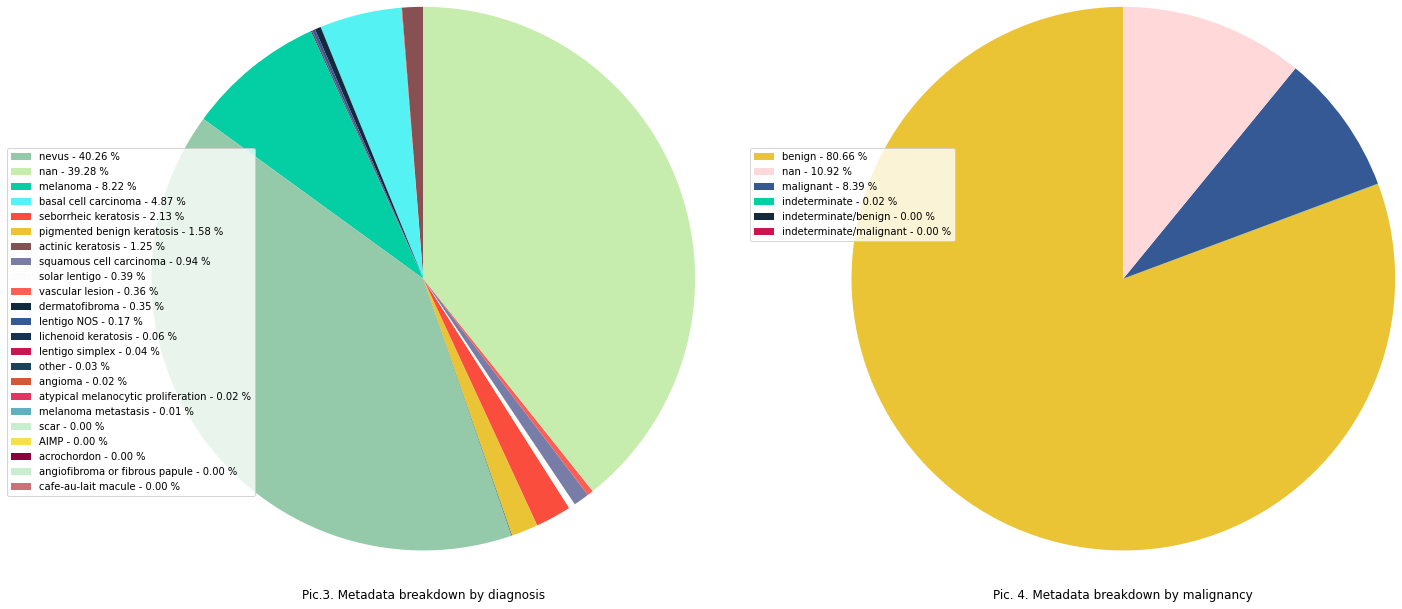

In [6]:
%matplotlib inline

plt.rcParams['axes.titley'] = -0.7

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(23,5))

# diagnosis plot
data = diagnosis_breaddown_metadata['size']
keys = diagnosis_breaddown_metadata['diagnosis']
palette_color = ['#333745', '#E63462', '#FE5F55', '#C7EFCF', '#C7EFCF', '#D5573B', '#885053', '#777DA7', '#94C9A9', '#C6ECAE', '#3E92CC', '#2A628F', '#13293D', '#16324F', '#18435A', '#F4E04D', '#FCFCFC', '#54F2F2', '#5EB1BF', '#042A2B', '#EAC435', '#345995', '#03CEA4', '#FB4D3D', '#CA1551', '#89023E', '#CC7178', '#FFD9DA', '#C7D9B7']
shuffle(palette_color)
percentages = 100. * data / data.sum()

# plotting data on chart
patches, texts = ax1.pie(data, colors=palette_color, startangle=90, radius=2.5)
labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(keys, percentages)]
patches, labels, dummy =  zip(*sorted(zip(patches, labels, data),
                                      key=lambda x: x[2],
                                      reverse=True))
ax1.set_title('Pic.3. Metadata breakdown by diagnosis')
ax1.legend(patches, labels, loc='upper right', bbox_to_anchor=(-0.1, 1.),
           fontsize=10)

# diagnosis plot
data = benign_malignant_breaddown_metadata['size']
keys = benign_malignant_breaddown_metadata['benign_malignant']
palette_color = ['#333745', '#E63462', '#FE5F55', '#C7EFCF', '#C7EFCF', '#D5573B', '#885053', '#777DA7', '#94C9A9', '#C6ECAE', '#3E92CC', '#2A628F', '#13293D', '#16324F', '#18435A', '#F4E04D', '#FCFCFC', '#54F2F2', '#5EB1BF', '#042A2B', '#EAC435', '#345995', '#03CEA4', '#FB4D3D', '#CA1551', '#89023E', '#CC7178', '#FFD9DA', '#C7D9B7']
shuffle(palette_color)
percentages = 100. * data / data.sum()

# plotting data on chart
patches, texts = ax2.pie(data, colors=palette_color, startangle=90, radius=2.5)
labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(keys, percentages)]
patches, labels, dummy =  zip(*sorted(zip(patches, labels, data),
                                      key=lambda x: x[2],
                                      reverse=True))

ax2.set_title('Pic. 4. Metadata breakdown by malignancy')
ax2.legend(patches, labels, loc='upper right', bbox_to_anchor=(-0.1, 1.),
           fontsize=10)

<a id='metadata_breakdowns'></a>
From the first pie chart, we see, that __39.28%__ samples don't have a diagnosis. We think, that the fact somehow correlates with the lesions' malignancy and the way the diagnosis' were obtained.

In [7]:
no_diagnosis_metadata = metadata[pd.isnull(metadata['diagnosis'])]

In [8]:
benign_malignant_breaddown_no_diagnosis_metadata = no_diagnosis_metadata.groupby(['benign_malignant'], dropna=False, as_index=False).size()

In [9]:
diagnosis_confirm_type_breaddown_no_diagnosis_metadata = no_diagnosis_metadata.groupby(['diagnosis_confirm_type'], dropna=False, as_index=False).size()

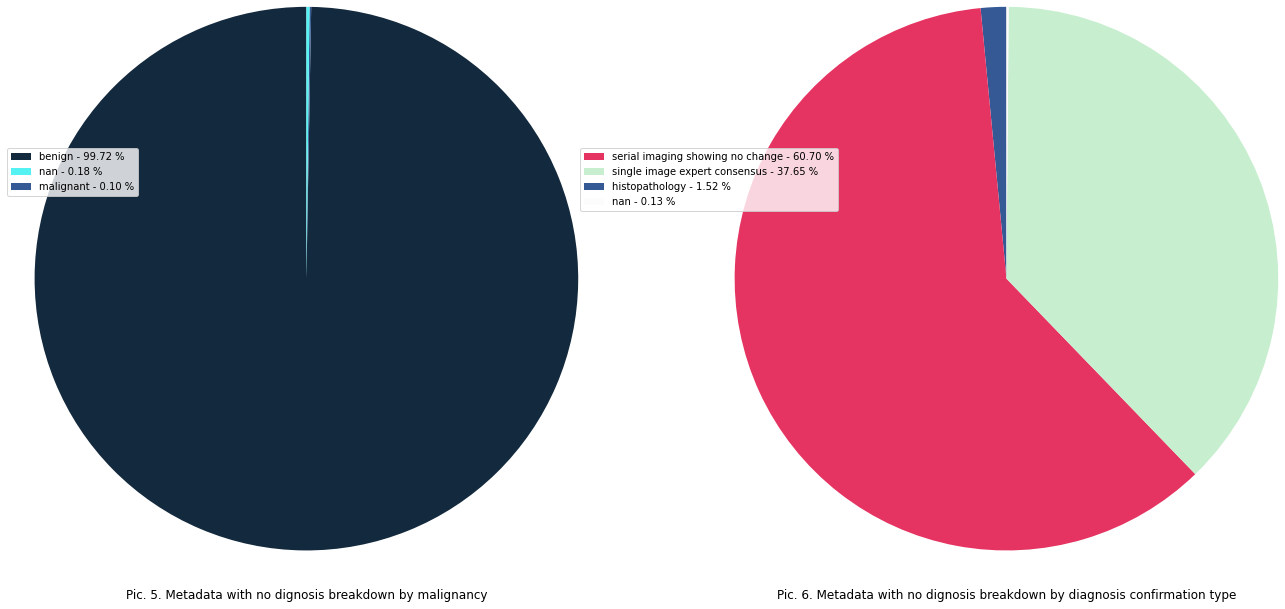

In [10]:
%matplotlib inline

plt.rcParams['axes.titley'] = -0.7

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(23,5))

# diagnosis plot
data = benign_malignant_breaddown_no_diagnosis_metadata['size']
keys = benign_malignant_breaddown_no_diagnosis_metadata['benign_malignant']
palette_color = ['#333745', '#E63462', '#FE5F55', '#C7EFCF', '#C7EFCF', '#D5573B', '#885053', '#777DA7', '#94C9A9', '#C6ECAE', '#3E92CC', '#2A628F', '#13293D', '#16324F', '#18435A', '#F4E04D', '#FCFCFC', '#54F2F2', '#5EB1BF', '#042A2B', '#EAC435', '#345995', '#03CEA4', '#FB4D3D', '#CA1551', '#89023E', '#CC7178', '#FFD9DA', '#C7D9B7']
shuffle(palette_color)
percentages = 100. * data / data.sum()

# plotting data on chart
patches, texts = ax1.pie(data, colors=palette_color, startangle=90, radius=2.5)
labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(keys, percentages)]
patches, labels, dummy =  zip(*sorted(zip(patches, labels, data),
                                      key=lambda x: x[2],
                                      reverse=True))
ax1.set_title('Pic. 5. Metadata with no dignosis breakdown by malignancy')
ax1.legend(patches, labels, loc='upper right', bbox_to_anchor=(-0.1, 1.),
           fontsize=10)

# diagnosis plot
data = diagnosis_confirm_type_breaddown_no_diagnosis_metadata['size']
keys = diagnosis_confirm_type_breaddown_no_diagnosis_metadata['diagnosis_confirm_type']
palette_color = ['#333745', '#E63462', '#FE5F55', '#C7EFCF', '#C7EFCF', '#D5573B', '#885053', '#777DA7', '#94C9A9', '#C6ECAE', '#3E92CC', '#2A628F', '#13293D', '#16324F', '#18435A', '#F4E04D', '#FCFCFC', '#54F2F2', '#5EB1BF', '#042A2B', '#EAC435', '#345995', '#03CEA4', '#FB4D3D', '#CA1551', '#89023E', '#CC7178', '#FFD9DA', '#C7D9B7']
shuffle(palette_color)
percentages = 100. * data / data.sum()

# plotting data on chart
patches, texts = ax2.pie(data, colors=palette_color, startangle=90, radius=2.5)
labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(keys, percentages)]
patches, labels, dummy =  zip(*sorted(zip(patches, labels, data),
                                      key=lambda x: x[2],
                                      reverse=True))

ax2.set_title('Pic. 6. Metadata with no dignosis breakdown by diagnosis confirmation type')
ax2.legend(patches, labels, loc='upper right', bbox_to_anchor=(-0.1, 1.),
           fontsize=10)

__99.72%__ of samples without a diagnosis are benign and only __1.52%__ are consirmed with histopathology research. 

Probably, because excision wasn't done, the hospital protocol allowed not to put exact diagnosis. But imaging researches were enough to conclude that the lesions were benign.

Let's see, what kind of research is made with the samples, which have diagnosis.

In [11]:
yes_diagnosis_metadata = metadata[pd.notnull(metadata['diagnosis'])]

In [12]:
benign_malignant_breaddown_yes_diagnosis_metadata = yes_diagnosis_metadata.groupby(['benign_malignant'], dropna=False, as_index=False).size()

In [13]:
diagnosis_confirm_type_breaddown_yes_diagnosis_metadata = yes_diagnosis_metadata.groupby(['diagnosis_confirm_type'], dropna=False, as_index=False).size()

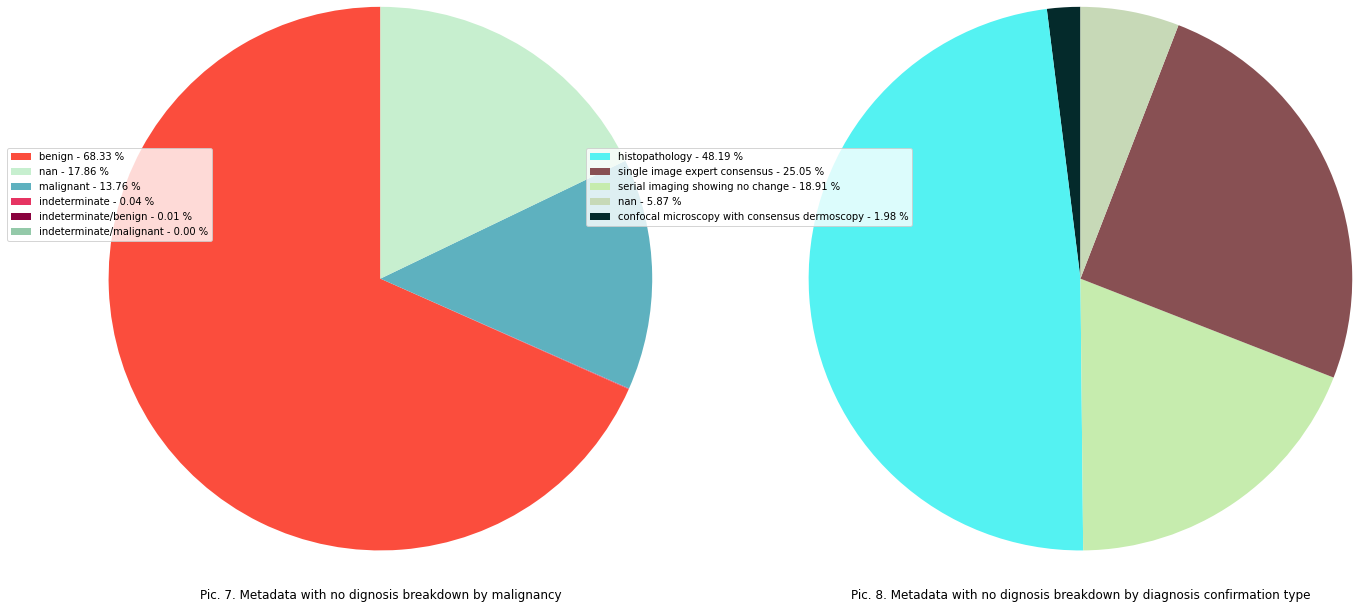

In [14]:
%matplotlib inline

plt.rcParams['axes.titley'] = -0.7

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(23,5))

# diagnosis plot
data = benign_malignant_breaddown_yes_diagnosis_metadata['size']
keys = benign_malignant_breaddown_yes_diagnosis_metadata['benign_malignant']
palette_color = ['#333745', '#E63462', '#FE5F55', '#C7EFCF', '#C7EFCF', '#D5573B', '#885053', '#777DA7', '#94C9A9', '#C6ECAE', '#3E92CC', '#2A628F', '#13293D', '#16324F', '#18435A', '#F4E04D', '#FCFCFC', '#54F2F2', '#5EB1BF', '#042A2B', '#EAC435', '#345995', '#03CEA4', '#FB4D3D', '#CA1551', '#89023E', '#CC7178', '#FFD9DA', '#C7D9B7']
shuffle(palette_color)
percentages = 100. * data / data.sum()

# plotting data on chart
patches, texts = ax1.pie(data, colors=palette_color, startangle=90, radius=2.5)
labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(keys, percentages)]
patches, labels, dummy =  zip(*sorted(zip(patches, labels, data),
                                      key=lambda x: x[2],
                                      reverse=True))
ax1.set_title('Pic. 7. Metadata with no dignosis breakdown by malignancy')
ax1.legend(patches, labels, loc='upper right', bbox_to_anchor=(-0.1, 1.),
           fontsize=10)

# diagnosis plot
data = diagnosis_confirm_type_breaddown_yes_diagnosis_metadata['size']
keys = diagnosis_confirm_type_breaddown_yes_diagnosis_metadata['diagnosis_confirm_type']
palette_color = ['#333745', '#E63462', '#FE5F55', '#C7EFCF', '#C7EFCF', '#D5573B', '#885053', '#777DA7', '#94C9A9', '#C6ECAE', '#3E92CC', '#2A628F', '#13293D', '#16324F', '#18435A', '#F4E04D', '#FCFCFC', '#54F2F2', '#5EB1BF', '#042A2B', '#EAC435', '#345995', '#03CEA4', '#FB4D3D', '#CA1551', '#89023E', '#CC7178', '#FFD9DA', '#C7D9B7']
shuffle(palette_color)
percentages = 100. * data / data.sum()

# plotting data on chart
patches, texts = ax2.pie(data, colors=palette_color, startangle=90, radius=2.5)
labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(keys, percentages)]
patches, labels, dummy =  zip(*sorted(zip(patches, labels, data),
                                      key=lambda x: x[2],
                                      reverse=True))

ax2.set_title('Pic. 8. Metadata with no dignosis breakdown by diagnosis confirmation type')
ax2.legend(patches, labels, loc='upper right', bbox_to_anchor=(-0.1, 1.),
           fontsize=10)

Out of the samples with diagnosis, much more of them were confirmed with a histopathological research - __48.18%__. But, and that's important, if a sample has a diagnosis, it doesn't mean, that it was confirmed with a histopathological research.

Let's go back to the [Pic. 4. Breakdown by malignancy](#metadata_breakdowns) . __10.92%__ of samples have unknown malignancy, so we will study it through diagnosis and other columns.

In [15]:
no_benign_malignant_metadata = metadata[pd.isnull(metadata['benign_malignant'])]

In [16]:
diagnosis_breakdown_no_benign_malignant_metadata = no_benign_malignant_metadata.groupby(['diagnosis'], dropna=False, as_index=False).size()

In [17]:
diagnosis_confirm_type_no_benign_malignant_metadata = no_benign_malignant_metadata.groupby(['diagnosis_confirm_type'], dropna=False, as_index=False).size()

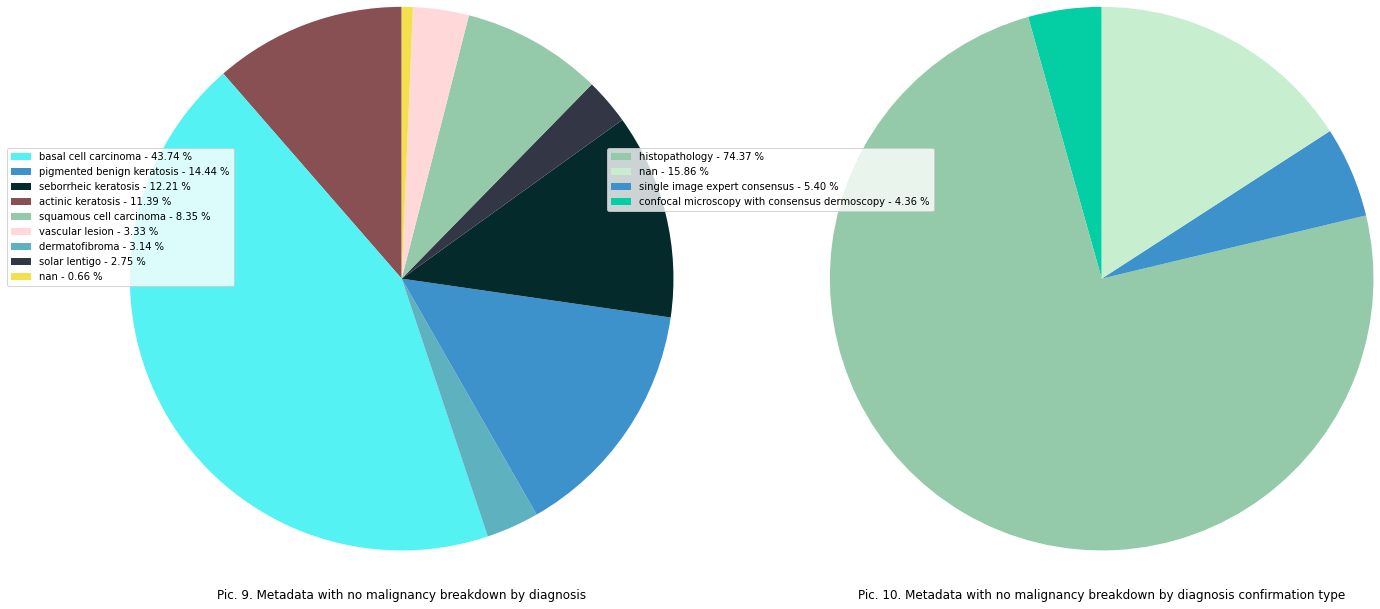

In [18]:
%matplotlib inline

plt.rcParams['axes.titley'] = -0.7

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(23,5))

# diagnosis plot
data = diagnosis_breakdown_no_benign_malignant_metadata['size']
keys = diagnosis_breakdown_no_benign_malignant_metadata['diagnosis']
palette_color = ['#333745', '#E63462', '#FE5F55', '#C7EFCF', '#C7EFCF', '#D5573B', '#885053', '#777DA7', '#94C9A9', '#C6ECAE', '#3E92CC', '#2A628F', '#13293D', '#16324F', '#18435A', '#F4E04D', '#FCFCFC', '#54F2F2', '#5EB1BF', '#042A2B', '#EAC435', '#345995', '#03CEA4', '#FB4D3D', '#CA1551', '#89023E', '#CC7178', '#FFD9DA', '#C7D9B7']
shuffle(palette_color)
percentages = 100. * data / data.sum()

# plotting data on chart
patches, texts = ax1.pie(data, colors=palette_color, startangle=90, radius=2.5)
labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(keys, percentages)]
patches, labels, dummy =  zip(*sorted(zip(patches, labels, data),
                                      key=lambda x: x[2],
                                      reverse=True))
ax1.set_title('Pic. 9. Metadata with no malignancy breakdown by diagnosis')
ax1.legend(patches, labels, loc='upper right', bbox_to_anchor=(-0.1, 1.),
           fontsize=10)

# diagnosis plot
data = diagnosis_confirm_type_no_benign_malignant_metadata['size']
keys = diagnosis_confirm_type_no_benign_malignant_metadata['diagnosis_confirm_type']
palette_color = ['#333745', '#E63462', '#FE5F55', '#C7EFCF', '#C7EFCF', '#D5573B', '#885053', '#777DA7', '#94C9A9', '#C6ECAE', '#3E92CC', '#2A628F', '#13293D', '#16324F', '#18435A', '#F4E04D', '#FCFCFC', '#54F2F2', '#5EB1BF', '#042A2B', '#EAC435', '#345995', '#03CEA4', '#FB4D3D', '#CA1551', '#89023E', '#CC7178', '#FFD9DA', '#C7D9B7']
shuffle(palette_color)
percentages = 100. * data / data.sum()

# plotting data on chart
patches, texts = ax2.pie(data, colors=palette_color, startangle=90, radius=2.5)
labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(keys, percentages)]
patches, labels, dummy =  zip(*sorted(zip(patches, labels, data),
                                      key=lambda x: x[2],
                                      reverse=True))

ax2.set_title('Pic. 10. Metadata with no malignancy breakdown by diagnosis confirmation type')
ax2.legend(patches, labels, loc='upper right', bbox_to_anchor=(-0.1, 1.),
           fontsize=10)

For the most cases, the issues is with incorrectly filled data:
- [Basal-cell carcinoma](https://en.wikipedia.org/wiki/Basal-cell_carcinoma) - malignant
- Pigmented benign ketosis - benign
- [Seborrheic keratosis](https://en.wikipedia.org/wiki/Seborrheic_keratosis) - benign
- [Actinic keratosis](https://en.wikipedia.org/wiki/Actinic_keratosis) - precancerous, untreated lesions have up to a 20% risk of progression to squamous cell carcinoma, for our purposes, we'll consider it malignant
- [Squamous cell carcinoma](https://en.wikipedia.org/wiki/Squamous_cell_carcinoma) - malignant
- [Vascular lesion](https://en.wikipedia.org/wiki/Vascular_anomaly) - benign
- [Dermatofibroma](https://en.wikipedia.org/wiki/Dermatofibroma) - benign
- [Solar lentigo](https://en.wikipedia.org/wiki/Liver_spot) - benign

Let's fix the data

In [19]:
metadata.loc[metadata['diagnosis'] == 'basal cell carcinoma', 'benign_malignant']  = 'malignant'
metadata.loc[metadata['diagnosis'] == 'pigmented benign keratosis', 'benign_malignant']  = 'benign'
metadata.loc[metadata['diagnosis'] == 'seborrheic keratosis', 'benign_malignant']  = 'benign'
metadata.loc[metadata['diagnosis'] == 'actinic keratosis', 'benign_malignant']  = 'malignant'
metadata.loc[metadata['diagnosis'] == 'squamous cell carcinoma', 'benign_malignant']  = 'malignant'
metadata.loc[metadata['diagnosis'] == 'vascular lesion', 'benign_malignant']  = 'benign'
metadata.loc[metadata['diagnosis'] == 'dermatofibroma', 'benign_malignant']  = 'benign'
metadata.loc[metadata['diagnosis'] == 'solar lentigo', 'benign_malignant']  = 'benign'

Returning to samples without a diagnosis, we have two ways out of this:
- remove the samples
- introduce a new "label"

We don't know much about those samples except that they contain all kind of benign skin conditions. So, for example, there will be __solar lentigo__ samples in the __solar lentigo__ subset and the undiagnosed subset. That will may lead to classifying __solar lentigo__ as a part of undiagnosed subset. That's why, it's better to exclude the undiagnosed samples from training.

In addition to that, the dataset is tilted toward benign skin conditions, and almost all undiagnosed samples represent benign skin conditions. In that way, we not only remove confusing data but perform undersampling to balance out the dataset.

In [20]:
metadata = metadata.drop(metadata[pd.isnull(metadata['diagnosis'])].index)

Later on we will need to split the dataset into training, validation and testing. To do that, all diagnoses should have sufficient amount of  samples.

In [21]:
diagnosis_numbers = metadata.groupby(['diagnosis'], dropna=False, as_index=False).size().sort_values(by='size')
diagnosis_numbers

,diagnosis,size
0,AIMP,1
1,acrochordon,1
3,angiofibroma or fibrous papule,1
7,cafe-au-lait macule,1
17,scar,3
13,melanoma metastasis,4
5,atypical melanocytic proliferation,14
4,angioma,15
15,other,24
10,lentigo simplex,27


We'll remove the samples, which are not part of the 10 most common diagnosis categories.

In [22]:
rare_diagnosis = diagnosis_numbers[:-10]['diagnosis']
rare_diagnosis

0                                   AIMP
1                            acrochordon
3         angiofibroma or fibrous papule
7                    cafe-au-lait macule
17                                  scar
13                   melanoma metastasis
5     atypical melanocytic proliferation
4                                angioma
15                                 other
10                       lentigo simplex
11                   lichenoid keratosis
9                            lentigo NOS
Name: diagnosis, dtype: object

In [23]:
metadata = metadata.drop(metadata[metadata['diagnosis'].isin(rare_diagnosis)].index)
metadata = metadata.drop(metadata[~metadata['benign_malignant'].isin(['benign', 'malignant'])].index)

Let's look at the breakdown now.

In [24]:
diagnosis_breaddown_metadata = metadata.groupby(['diagnosis'], dropna=False, as_index=False).size()

In [25]:
benign_malignant_breaddown_metadata = metadata.groupby(['benign_malignant'], dropna=False, as_index=False).size()

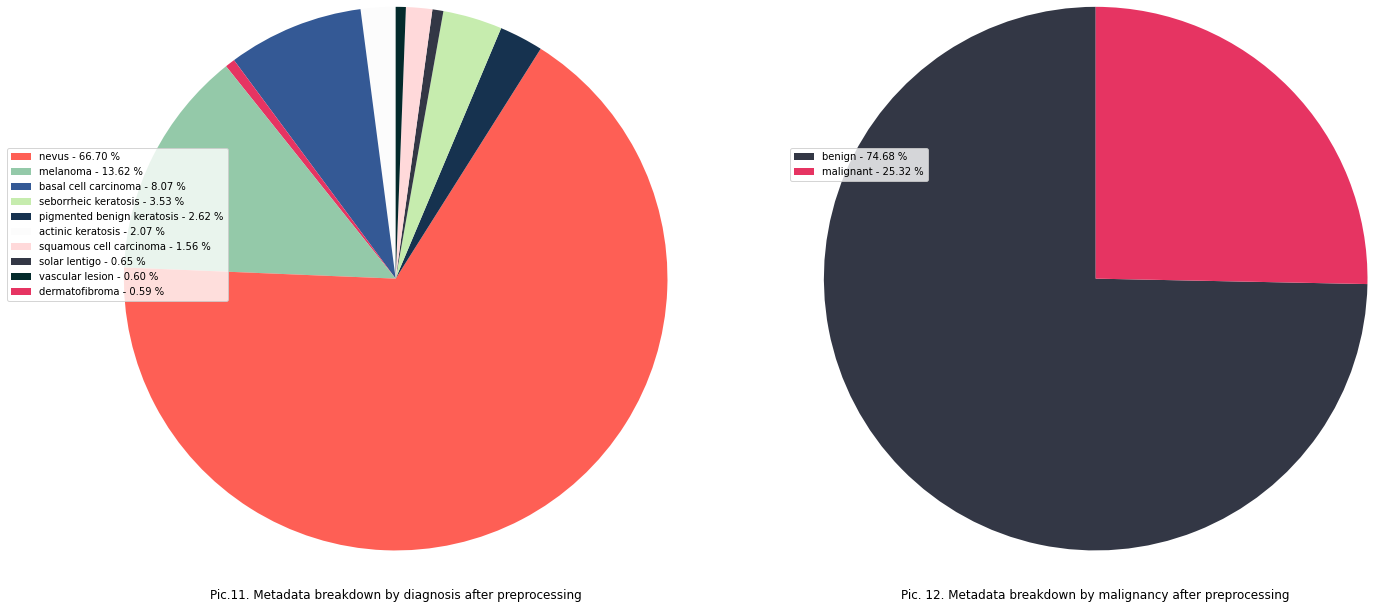

In [26]:
%matplotlib inline

plt.rcParams['axes.titley'] = -0.7

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(23,5))

# diagnosis plot
data = diagnosis_breaddown_metadata['size']
keys = diagnosis_breaddown_metadata['diagnosis']
palette_color = ['#333745', '#E63462', '#FE5F55', '#C7EFCF', '#C7EFCF', '#D5573B', '#885053', '#777DA7', '#94C9A9', '#C6ECAE', '#3E92CC', '#2A628F', '#13293D', '#16324F', '#18435A', '#F4E04D', '#FCFCFC', '#54F2F2', '#5EB1BF', '#042A2B', '#EAC435', '#345995', '#03CEA4', '#FB4D3D', '#CA1551', '#89023E', '#CC7178', '#FFD9DA', '#C7D9B7']
shuffle(palette_color)
percentages = 100. * data / data.sum()

# plotting data on chart
patches, texts = ax1.pie(data, colors=palette_color, startangle=90, radius=2.5)
labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(keys, percentages)]
patches, labels, dummy =  zip(*sorted(zip(patches, labels, data),
                                      key=lambda x: x[2],
                                      reverse=True))
ax1.set_title('Pic.11. Metadata breakdown by diagnosis after preprocessing')
ax1.legend(patches, labels, loc='upper right', bbox_to_anchor=(-0.1, 1.),
           fontsize=10)

# diagnosis plot
data = benign_malignant_breaddown_metadata['size']
keys = benign_malignant_breaddown_metadata['benign_malignant']
palette_color = ['#333745', '#E63462', '#FE5F55', '#C7EFCF', '#C7EFCF', '#D5573B', '#885053', '#777DA7', '#94C9A9', '#C6ECAE', '#3E92CC', '#2A628F', '#13293D', '#16324F', '#18435A', '#F4E04D', '#FCFCFC', '#54F2F2', '#5EB1BF', '#042A2B', '#EAC435', '#345995', '#03CEA4', '#FB4D3D', '#CA1551', '#89023E', '#CC7178', '#FFD9DA', '#C7D9B7']
percentages = 100. * data / data.sum()

# plotting data on chart
patches, texts = ax2.pie(data, colors=palette_color, startangle=90, radius=2.5)
labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(keys, percentages)]
patches, labels, dummy =  zip(*sorted(zip(patches, labels, data),
                                      key=lambda x: x[2],
                                      reverse=True))

ax2.set_title('Pic. 12. Metadata breakdown by malignancy after preprocessing')
ax2.legend(patches, labels, loc='upper right', bbox_to_anchor=(-0.1, 1.),
           fontsize=10)

The dataset is still imbalanced, so we'll calculate class weights to use them in training.

In [27]:
class_weights = metadata.groupby(['diagnosis'], dropna=False, as_index=False).size()
class_weights.loc[:, 'size'] =  1 / class_weights.loc[:, 'size']
class_weights.loc[:, 'size'] *= ( len(metadata) / 10 )
class_weights

,diagnosis,size
0,actinic keratosis,4.840506
1,basal cell carcinoma,1.238634
2,dermatofibroma,17.029960
3,melanoma,0.734229
4,nevus,0.149934
5,pigmented benign keratosis,3.824000
6,seborrheic keratosis,2.832593
7,solar lentigo,15.351825
8,squamous cell carcinoma,6.412195
9,vascular lesion,16.626087


In [28]:
class_weights = dict(enumerate(class_weights['size']))

We transform ISIC ids to filenames. 

In [29]:
metadata['isic_id'] += '.jpg'

We need to extract testing files from the dataset.

In [30]:
rest_set, testing_set = train_test_split(metadata, test_size=0.1)

Finally, we can load the images.

In [31]:
generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=180,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=(0.2, 1.5),
    validation_split=0.2,
)

training_set = generator.flow_from_dataframe(
    rest_set,
    directory=f"{os.environ['SCRATCH']}/isic-archive",
    x_col='isic_id',
    y_col='diagnosis',
    
    target_size=(299, 299), 
    batch_size=32, 
    class_mode='categorical', 
    subset='training'
)

validation_set = generator.flow_from_dataframe(
    rest_set,
    directory=f"{os.environ['SCRATCH']}/isic-archive",
    x_col='isic_id',
    y_col='diagnosis',
    
    target_size=(299, 299), 
    batch_size=32, 
    class_mode='categorical', 
    subset='validation'
)

testing_set = generator.flow_from_dataframe(
    testing_set,
    directory=f"{os.environ['SCRATCH']}/isic-archive",
    x_col='isic_id',
    y_col='diagnosis',
    
    target_size=(299, 299), 
    batch_size=32, 
    class_mode='categorical'
)

Found 30286 validated image filenames belonging to 10 classes.
Found 7571 validated image filenames belonging to 10 classes.
Found 4207 validated image filenames belonging to 10 classes.


In [32]:
CLASS_NUMBER = len(training_set.class_indices)

## Data source

As a data source, we use the ISIC Archive.

The ISIC Archive is an open source platform with publicly available images of skin lesions under Creative Commons licenses. The images are associated with ground-truth diagnoses and other clinical metadata. Images can be queried using faceted search and downloaded individually or in batches. The initial focus of the archive has been on dermoscopy images of individual skin lesions, as these images are inherently standardized by the use of a specialized acquisition device and devoid of many of the privacy challenges associated with clinical images. To date, the images have been provided by specialized melanoma centers from around the world. The archive is designed to accept contributions from new sources under the Terms of Use and welcomes new contributors. There are ongoing efforts to supplement the dermoscopy images in the archive with close-up clinical images and a broader representation of skin types. The images in the Archive are used to support educational efforts through linkage with Dermoscopedia and are used for Grand Challenges and Live Challenges to engage the computer science community for the development of diagnostic AI.

For more information, go to [ISIC Archive web site](https://www.isic-archive.com/)

# Model training

We define the model

In [33]:
class Classifier(tf.keras.Model):
    def __init__(self, class_number):
        super(Classifier, self).__init__()
        
        self.inception_model = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(
            include_top=False,
            weights='imagenet',
            input_shape=(299, 299, 3),
            pooling='avg'
        )
        for layer in self.inception_model.layers:
            if layer.name in ['conv_7b', 'block8_10_conv']:
                layer.trainable = True
            else:
                layer.trainable = False
        self.dense = tf.keras.layers.Dense(class_number, activation='softmax')
        
    def call(self, inputs):
        outputs = self.inception_model(inputs)
        outputs = self.dense(outputs)
        
        return outputs
        

... and the callbacks for it

In [34]:
checkpoint_path = 'checkpoints/model.ckpt'

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    save_freq='epoch',
    mode='auto'
)

In [35]:
early_stop_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", 
    min_delta=0.01, 
    patience=5, 
    restore_best_weights=True
)

We define distribution strategy

In [36]:
strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


... and train the model.

In [37]:
with strategy.scope():
    classifier = Classifier(class_number=CLASS_NUMBER)
    classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

In [38]:
classifier.fit(
    training_set, 
    validation_data=validation_set, 
    epochs=30,
    callbacks=[
        early_stop_callback,
        checkpoint_callback
    ]
)

Epoch 1/30
INFO:tensorflow:batch_all_reduce: 5 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 5 all-reduces with algorithm = nccl, num_packs = 1
947/947 [==============================] - ETA: 0s - loss: 0.8115 - accuracy: 0.7325
Epoch 1: val_loss improved from inf to 0.72787, saving model to checkpoints/model.ckpt


INFO:tensorflow:Assets written to: checkpoints/model.ckpt/assets


INFO:tensorflow:Assets written to: checkpoints/model.ckpt/assets


947/947 [==============================] - 5792s 6s/step - loss: 0.8115 - accuracy: 0.7325 - val_loss: 0.7279 - val_accuracy: 0.7526
Epoch 2/30
947/947 [==============================] - ETA: 0s - loss: 0.7109 - accuracy: 0.7569
Epoch 2: val_loss improved from 0.72787 to 0.71896, saving model to checkpoints/model.ckpt


INFO:tensorflow:Assets written to: checkpoints/model.ckpt/assets


INFO:tensorflow:Assets written to: checkpoints/model.ckpt/assets


947/947 [==============================] - 6745s 7s/step - loss: 0.7109 - accuracy: 0.7569 - val_loss: 0.7190 - val_accuracy: 0.7609
Epoch 3/30
947/947 [==============================] - ETA: 0s - loss: 0.6758 - accuracy: 0.7670
Epoch 3: val_loss improved from 0.71896 to 0.69429, saving model to checkpoints/model.ckpt


INFO:tensorflow:Assets written to: checkpoints/model.ckpt/assets


INFO:tensorflow:Assets written to: checkpoints/model.ckpt/assets


947/947 [==============================] - 5876s 6s/step - loss: 0.6758 - accuracy: 0.7670 - val_loss: 0.6943 - val_accuracy: 0.7601
Epoch 4/30
947/947 [==============================] - ETA: 0s - loss: 0.6472 - accuracy: 0.7777
Epoch 4: val_loss improved from 0.69429 to 0.67009, saving model to checkpoints/model.ckpt


INFO:tensorflow:Assets written to: checkpoints/model.ckpt/assets


INFO:tensorflow:Assets written to: checkpoints/model.ckpt/assets


947/947 [==============================] - 6568s 7s/step - loss: 0.6472 - accuracy: 0.7777 - val_loss: 0.6701 - val_accuracy: 0.7743
Epoch 5/30
947/947 [==============================] - ETA: 0s - loss: 0.6349 - accuracy: 0.7789
Epoch 5: val_loss improved from 0.67009 to 0.66041, saving model to checkpoints/model.ckpt


INFO:tensorflow:Assets written to: checkpoints/model.ckpt/assets


INFO:tensorflow:Assets written to: checkpoints/model.ckpt/assets


947/947 [==============================] - 4220s 4s/step - loss: 0.6349 - accuracy: 0.7789 - val_loss: 0.6604 - val_accuracy: 0.7685
Epoch 6/30
947/947 [==============================] - ETA: 0s - loss: 0.6173 - accuracy: 0.7857
Epoch 6: val_loss did not improve from 0.66041
947/947 [==============================] - 4243s 4s/step - loss: 0.6173 - accuracy: 0.7857 - val_loss: 0.6738 - val_accuracy: 0.7686
Epoch 7/30
947/947 [==============================] - ETA: 0s - loss: 0.6057 - accuracy: 0.7873
Epoch 7: val_loss did not improve from 0.66041
947/947 [==============================] - 3889s 4s/step - loss: 0.6057 - accuracy: 0.7873 - val_loss: 0.7154 - val_accuracy: 0.7522
Epoch 8/30
947/947 [==============================] - ETA: 0s - loss: 0.5929 - accuracy: 0.7942
Epoch 8: val_loss improved from 0.66041 to 0.64889, saving model to checkpoints/model.ckpt


INFO:tensorflow:Assets written to: checkpoints/model.ckpt/assets


INFO:tensorflow:Assets written to: checkpoints/model.ckpt/assets


947/947 [==============================] - 3591s 4s/step - loss: 0.5929 - accuracy: 0.7942 - val_loss: 0.6489 - val_accuracy: 0.7764
Epoch 9/30
947/947 [==============================] - ETA: 0s - loss: 0.5825 - accuracy: 0.7952
Epoch 9: val_loss did not improve from 0.64889
947/947 [==============================] - 3376s 4s/step - loss: 0.5825 - accuracy: 0.7952 - val_loss: 0.6802 - val_accuracy: 0.7728
Epoch 10/30
947/947 [==============================] - ETA: 0s - loss: 0.5718 - accuracy: 0.7997
Epoch 10: val_loss did not improve from 0.64889
947/947 [==============================] - 3349s 4s/step - loss: 0.5718 - accuracy: 0.7997 - val_loss: 0.6598 - val_accuracy: 0.7735
Epoch 11/30
947/947 [==============================] - ETA: 0s - loss: 0.5588 - accuracy: 0.8029
Epoch 11: val_loss improved from 0.64889 to 0.64063, saving model to checkpoints/model.ckpt


INFO:tensorflow:Assets written to: checkpoints/model.ckpt/assets


INFO:tensorflow:Assets written to: checkpoints/model.ckpt/assets


947/947 [==============================] - 3435s 4s/step - loss: 0.5588 - accuracy: 0.8029 - val_loss: 0.6406 - val_accuracy: 0.7809
Epoch 12/30
947/947 [==============================] - ETA: 0s - loss: 0.5570 - accuracy: 0.8034
Epoch 12: val_loss did not improve from 0.64063
947/947 [==============================] - 3694s 4s/step - loss: 0.5570 - accuracy: 0.8034 - val_loss: 0.6595 - val_accuracy: 0.7764
Epoch 13/30
947/947 [==============================] - ETA: 0s - loss: 0.5458 - accuracy: 0.8081
Epoch 13: val_loss did not improve from 0.64063
947/947 [==============================] - 3348s 4s/step - loss: 0.5458 - accuracy: 0.8081 - val_loss: 0.6661 - val_accuracy: 0.7718


Let's check the model composition.

In [39]:
classifier.summary()

Model: "classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, 1536)             54336736  
 onal)                                                           
                                                                 
 dense (Dense)               multiple                  15370     
                                                                 
Total params: 54,352,106
Trainable params: 4,144,170
Non-trainable params: 50,207,936
_________________________________________________________________


In [40]:
classifier.inception_model.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                               

We want to plot the [Receiver operating characteristic](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) curve to see the model's performance. The bigger the area under the curve, the better is the performance.

Let's load the model from the checkpoint, because it has the least validation loss.

In [41]:
classifier.load_weights(checkpoint_path)

We load the ground truth diagnoses from the testing data.

In [42]:
groundtruth_labels = np.concatenate([testing_set[i][1] for i in range(len(testing_set))], axis=0)

We do inference on the testing data.

In [43]:
predicted_labels = classifier.predict(testing_set)

132/132 [==============================] - 272s 2s/step


And finally, after all preparations, we plot the ROC curve.

In [44]:
fpr = dict()
tpr = dict()
auc_metric = dict()

diagnosis_index_dict = {v: k for k, v in testing_set.class_indices.items()}

for i in range(len(diagnosis_index_dict)):
    diagnosis = diagnosis_index_dict[i]
    fpr[diagnosis], tpr[diagnosis], _ = roc_curve(groundtruth_labels[:, i], predicted_labels[:, i])
    auc_metric[diagnosis] = auc(fpr[diagnosis], tpr[diagnosis])

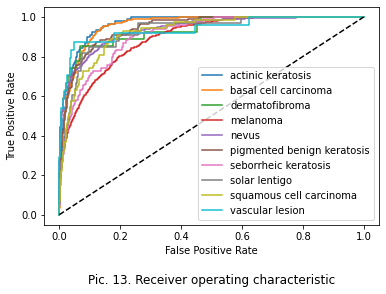

In [45]:
%matplotlib inline 

plt.rcParams['axes.titley'] = -0.3

for diagnosis in testing_set.class_indices:
    plt.plot(fpr[diagnosis], tpr[diagnosis], label=diagnosis)
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Pic. 13. Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [46]:
auc_metric

{'actinic keratosis': 0.9638274903516585,
 'basal cell carcinoma': 0.9586952769084126,
 'dermatofibroma': 0.9364522417153995,
 'melanoma': 0.892319235097777,
 'nevus': 0.9384102014062687,
 'pigmented benign keratosis': 0.945281537272443,
 'seborrheic keratosis': 0.9087559827080438,
 'solar lentigo': 0.9294986278694951,
 'squamous cell carcinoma': 0.9243825012757553,
 'vascular lesion': 0.9372161128376764}

Now we want some explanations from out model.

We load an image with melanoma

In [47]:
melanoma_im_path = f"{os.environ['SCRATCH']}/isic-archive/ISIC_0000031.jpg"

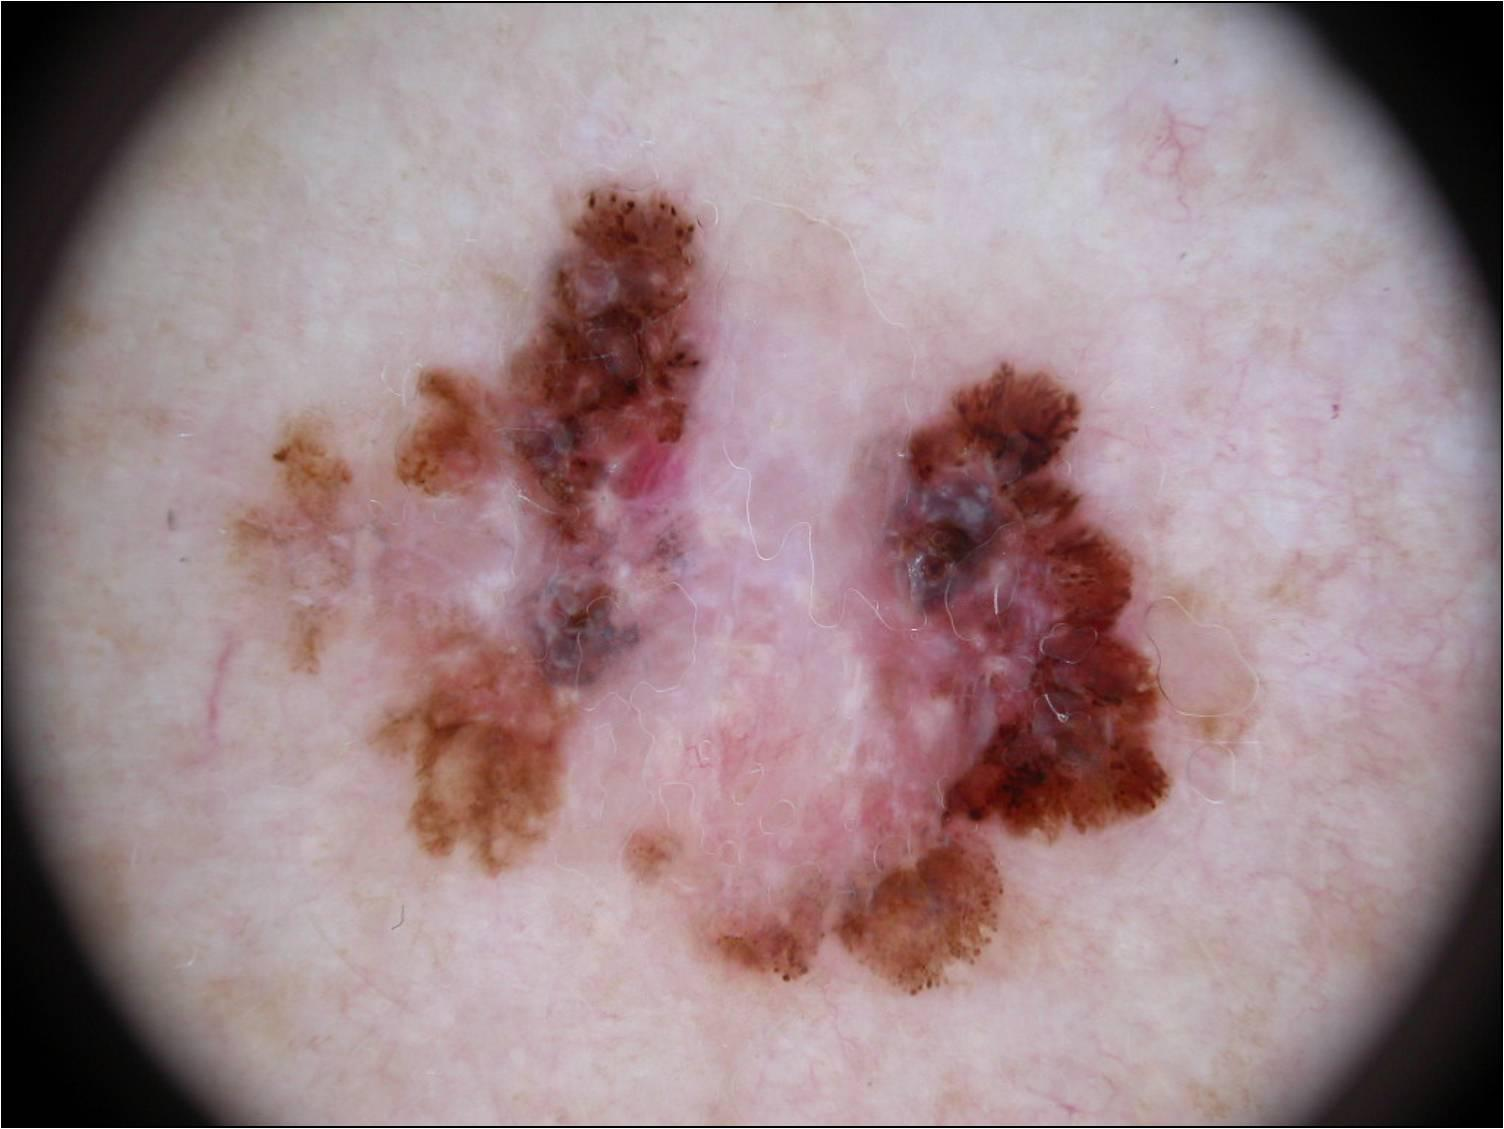

In [48]:
display(Image(melanoma_im_path, width=600))

Pic. 14. Image with melanoma.

In [49]:
def get_img_array(img_path, size):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    array = tf.keras.preprocessing.image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

In [50]:
img_array = tf.keras.applications.inception_resnet_v2.preprocess_input(get_img_array(melanoma_im_path, size=(299, 299)))

and plot Grad-CAM over the melanoma image,

In [51]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [52]:
heatmap = make_gradcam_heatmap(img_array, classifier.inception_model, 'conv_7b')

In [53]:
def display_gradcam(img_path, heatmap, alpha=0.4):
    img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)
    
    heatmap = np.uint8(255 * heatmap)
    
    jet = cm.get_cmap("jet")
    
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)
    
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)
    superimposed_img = superimposed_img.resize((np.array(superimposed_img.size) * 600 / 1504).astype(int))


    display(superimposed_img)

In [54]:
def display_gradcam(img_path, heatmap, alpha=0.4):
    img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)
    
    heatmap = np.uint8(255 * heatmap)
    
    jet = cm.get_cmap("jet")
    
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)
    
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)
    superimposed_img = superimposed_img.resize((np.array(superimposed_img.size) * 600 / 1504).astype(int))


    display(superimposed_img)

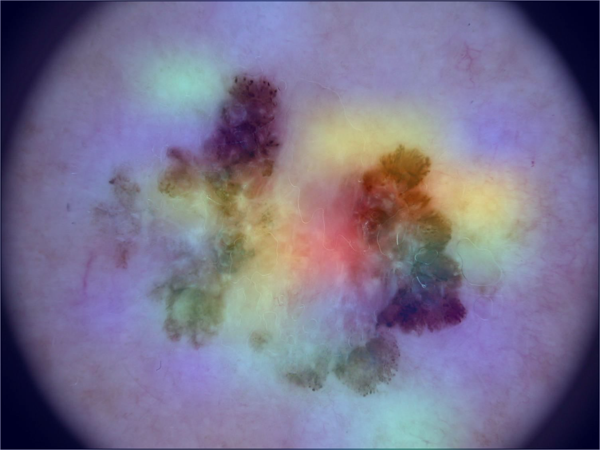

In [55]:
display_gradcam(melanoma_im_path, heatmap)

Pic. 15. Grad-CAM image of the melanoma.